# Lane Detection in image
 Using Opencv, matplotlib, pyplot, numpy, python
 > This program is for a better understanding of image processing for lane detection. Theory required for this process is at the end of the program, have a look at it for detailed explanation of the concepts.

In [1]:
# imports (install python, opencv and matplotlib in your system before importing)

import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from numpy.lib.arraysetops import _intersect1d_dispatcher
%matplotlib inline

In [2]:
# Different steps or Methods to be performed

def canny(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)      # Convert from RBG to grayScale
    blur = cv2.GaussianBlur(gray, (5,5), 0)             # Smoothen the image by removing noise
    canny_image = cv2.Canny(blur, 50, 150)              # Low and High thresholds are 50 and 150, 1:3 ratio
    return canny_image

def region_of_interest(image):
    height = image.shape[0]                             # vertices 90 860 470 300 for test_images
    left_lane_start = 90       # These vertices are not standard, this program is built on the conditon that the camera position on the vehicle is fixed, which intern generate standard images
    right_lane_start = 860
    left_lane_end = 476
    right_lane_end = 300
    
    polygons = np.array([                               # An array of polygons (here only one polygon, i.e, triangle)
        [(left_lane_start, height), (right_lane_start, height), (left_lane_end, right_lane_end)]      
    ])

    mask = np.zeros_like(image)                   # Mask all pixels to Zero
    cv2.fillPoly(mask, polygons, 255)             # color = 255(white).Filling the region of interest ,i.e, triangle form
    masked_image = cv2.bitwise_and(image, mask)   # Masking the unnecessary region
    return masked_image

def make_coordinates(image, line_parameters):
    slope, intercept = line_parameters
    y1 = image.shape[0]
    y2 = int(y1*(3/5))
    x1 = int((y1-intercept)/slope)
    x2 = int((y2-intercept)/slope)
    return np.array([x1,y1,x2,y2])

def average_slope_intercept(image, lines):    # To avoid overlaping of different lines we take the average of the lines and represent a single line using this function
    left_fit = []                             # contains coordinates(slope, intercept) of the left line
    right_fit = [] 
    print                                     # contains coordinates(slope, intercept) of the right line
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        parameters = np.polyfit((int(x1), int(x2)), (int(y1), int(y2)), 1)  # It stores slope and y-intercept at 0 and 1 index
        slope = parameters[0] 
        intercept = parameters[1]
        if slope < 0:
            left_fit.append((slope, intercept))
        else:
            right_fit.append((slope, intercept))
    left_fit_average = np.average(left_fit, axis=0)
    right_fit_average = np.average(right_fit, axis=0)
    left_line = make_coordinates(image, left_fit_average)
    right_line = make_coordinates(image, right_fit_average)
    return np.array([left_line, right_line])

def display_lines(image, lines):                        # lines is a 3d array
    line_image = np.zeros_like(image)
    if lines is not None:                               # check wether the array is empty or not to findout wether lines are detected or not
        for x1, y1, x2, y2 in lines:
            cv2.line(line_image, (x1,y1), (x2,y2), (255, 0, 0), 10)
    return line_image


In [3]:
# List of images to test
import os
os.listdir("test-images/")

['.ipynb_checkpoints', 'test_image2.jpg', 'test_image3.jpg', 'test_image4.jpg']

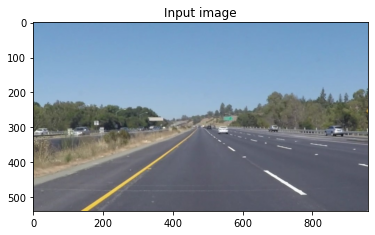

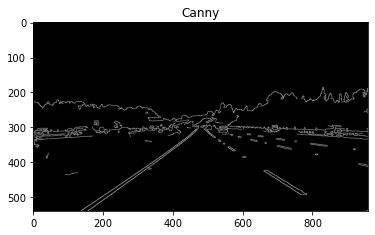

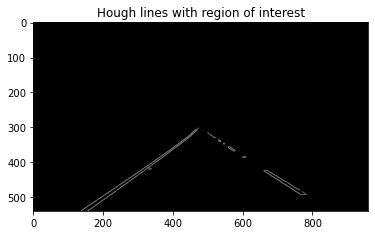

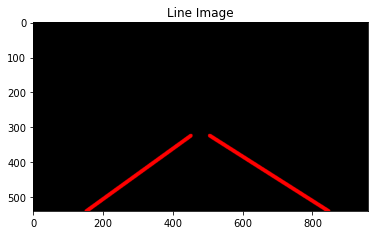

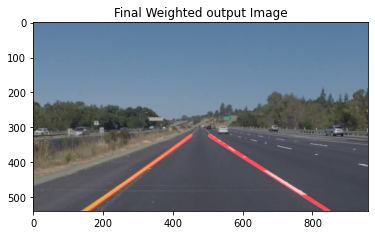

In [4]:
# __main__ Image detection for better understanding

image = mpimg.imread('test-images/test_image4.jpg')

lane_image = np.copy(image)             # To make sure changes are not made on the original image make a copy
canny_image = canny(lane_image)
cropped_image = region_of_interest(canny_image)

# Now let's run the Hough lines
rho = 2                 # distance resolution in pixels of the Hough grid
theta = np.pi/180       # angular resolution in radians of the Hough grid
threshold = 100         # minimum number of votes (intersections in Hough grid cell)
min_line_length = 30    # minimum number of pixels making up a line
max_line_gap = 3        # maximum gap in pixels between connectable line segments

lines = cv2.HoughLinesP(cropped_image, rho, theta, threshold, np.array([]), minLineLength=min_line_length, maxLineGap=max_line_gap)

averaged_lines = average_slope_intercept(lane_image, lines)
line_image = display_lines(lane_image, averaged_lines)
combo_image = cv2.addWeighted(lane_image, 0.8, line_image, 1, 1)

plt.imshow(image, cmap='gray')
plt.title("Input image")
plt.show()

plt.imshow(canny_image, cmap='gray')
plt.title("Canny")
plt.show()

plt.imshow(cropped_image, cmap='gray')
plt.title("Hough lines with region of interest")
plt.show()

plt.imshow(line_image, cmap='gray')
plt.title("Line Image")
plt.show()

plt.imshow(combo_image, cmap='gray')
plt.title("Final Weighted output Image")
plt.show()


# Theory
## Steps and methods involved
### Step-1: Convert the image to GrayScale
As we know, images are made up of pixels, our input colored image has 3 channels (Red, Green, Blue) here each pixel is a combination of three intensities. Where as a Grey-Scale image only has 1 channel each pixel with only 1 intensity value ranging from 0 to 255. So, by using a GrayScale image processing a single channel is faster than processing a three channel color image.
### Step-2: Reduce noise in an image
* When detecting edges, we must filter-out any image noise. Image noise can create false edges and ultimately effect edge detection, that's why its necessary to filter the noise and thus smoothen the image.
* This process is implemented using Gaussian Blur,"How do you do it?". As we know image is stored as a collection of pixels,  each pixel is represented by a single number that discribes the brightness of a pixel. We modify the value of a pixel with the average values of the pixel intensities around it. Averaging out the pixels will be done with a kernel, essentially this kernel of normally distributed numbers is run across our entire image and sets each pixel value equal to the average of its neighbouring image.
                        blur = cv2.GaussianBlur(gray, (5,5), 0)
      This indicates that we are applying a gaussian blur on grayScale image with a 5 by 5 kernel, the size of the kernel depends on specific situation. This returns a smoothed image (reduced noise)

### Step-3: Apply Canny method to identify edges in our image
* An edge corresponds to a region where there is a sharp change in intensity or color between adjacent pixels in the image.Pixels in the image can be read as a matrix. The change in brightness over a series of pixels is called "gradient". A strong gradient (example:[0 0 255 255]) indicates great change where as small gradient (example:[0 0 20 20]) shallow change. We can represent this in a graph.

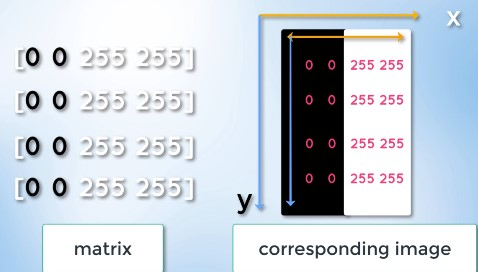

* what a canny function does? It measures adjacent changes in intensity in all directions, x and y. It produces a Gradient image by tracing the edge with large change in intensity (large gradient) in an outline of white pixels. The ratio recommended to use between low and high thresholds is 1:3 or 1:2 by the documentation

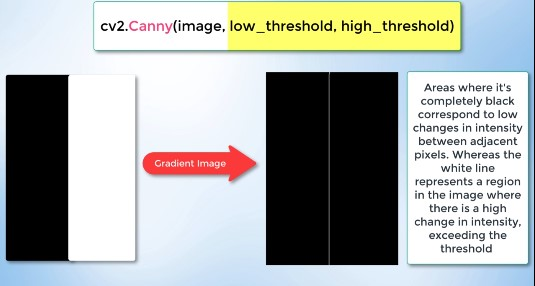

### step-4: Find the region of interest by finding the vertices, using matplotlib, and forming a triangle
* Let us consider a sample image, which looks like this after applying the canny function

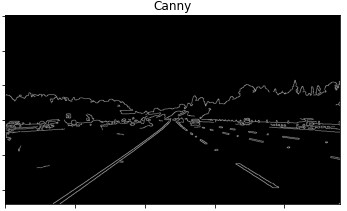

* Now we need to find the area of interest from the above image, "how do you get this area of interest?". we plot the image using pyplot from matplotlib library and note the vertices of the triangle region where the required lane region is present. If you observe the image below we can find a triangle with vertices left_lane_start=100 right_lane_start=860 left_lane_end=470 right_lane_end=300. We consider that the position of the camera is stable in our system so all the images captured have same vertices the region of interest forming a tirangle.  

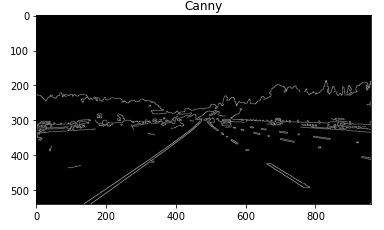

* After the canny_image with region of interest, we mask the image by performming a Bitwise_and operation on the canny_image and mask_image (which consists of zeros as its pixel values) which results in filtering the unnecessary region from the image and outputs the below image.

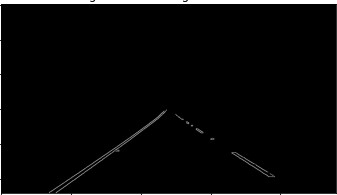


### step-5: Hough Transform:
    What is hough transform you ask?
* y = mx+b  [Stright line equation with parameters m and b]

    b = y-intercept

    m = (change in y) / (change in x)

    image space is a fucntion of plot x and y

    hough space is a function of plot m and b

    Note that a single point in image space is represented by a line in hough space, as shown below

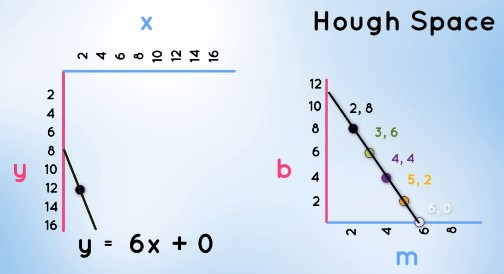

* Consider a sample image space and its corresponding hough space as shown below,

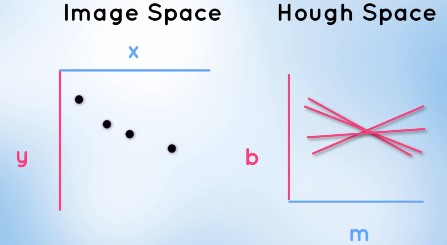
* we first split our hough space into a grid (bins), each bin corresponding to the slope and y-intercept value of a candidate line. For every point of interception we are going to cast a vote inside of the bin it belongs to.

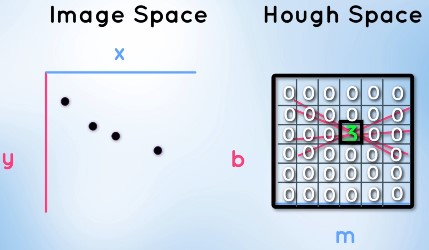
* The bin with the maxium number of votes is going to be our line, what ever the m and b value this bin belongs to that's the line we are going to draw as it is the best fit in discribing our data.

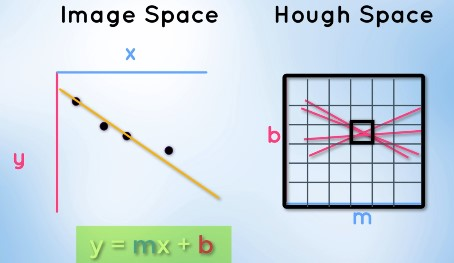
* But there is an error associated with this model. If you calculate the slope of a vertical line you get "infinity", which is a big "NO".

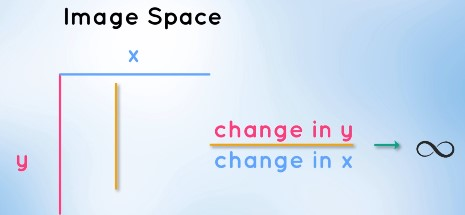

* To avoid these types of numerical problems, we use polar coordinate system, i.e, row and data

                    p = xcos(@) + ysin(@) where p = row and @ = theta 

        p = xcos(@) + ysin(@) is a line equation in polar coordinates

        where p = perpendicular distance from the origin and @ = angle of inclination of normal line from x-axis

* Now, with polar coordinates for a given point in image space we get a curve in hough space that is a plot of p and @.This curve represents all the lines passing through that point in image space.

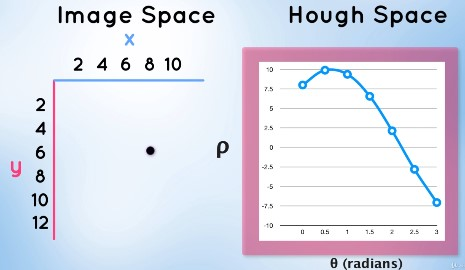

* Now the concept is same as before, we find the bin with max interceptions of curevs.

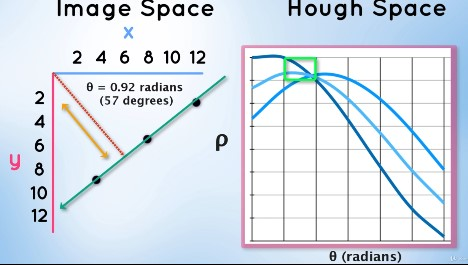

### Finally
* You finally made it. These are all the concepts that are required in this program. Now, have a look at the code and check your knowledge